In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
import os

from ensemblecalibration.data.synthetic.binary_new import BinaryExperiment
from ensemblecalibration.meta_model import (
    CredalSetCalibrator,
    LinearCalibrator,
    DirichletCalibrator,
    TemperatureScalingCalibrator,
    MLPCalW
)
from ensemblecalibration.losses.proper_losses import GeneralizedBrierLoss, GeneralizedLogLoss
from ensemblecalibration.data.dataset import MLPDataset
from ensemblecalibration.data.synthetic import create_synthetic_dataset
from ensemblecalibration.meta_model.train import train_model
from ensemblecalibration.utils.plot_functions import plot_ens_comb_cal
from ensemblecalibration.cal_estimates import get_skce_ul, get_ece_kde, brier_obj, mmd_kce
from ensemblecalibration.config import load_config

In [2]:
# losses to test
losses = {
    "brier": GeneralizedBrierLoss(),
    "log": GeneralizedLogLoss()
}
# metrics to test: 
metrics = {
    "skce": get_skce_ul,
    "ece": get_ece_kde,
    "brier": brier_obj,
    "mmd": mmd_kce
}
# recalibration methods
cal_methods = {
    "dirichlet": DirichletCalibrator,
    "temperature": TemperatureScalingCalibrator
}

### 1. Experiment: Gaussian Process Data


In [3]:
# load dictionary with configuration data:
config = load_config("../configs/gp_experiment.yml")
dataset_cfg = config["dataset"]
dataset_method = dataset_cfg["method"]

In [4]:
# create datasets
train_set, val_set, test_set = create_synthetic_dataset(dataset_cfg)
# train_set.indices


In [5]:
p_true_train = train_set.dataset.p_true[train_set.indices]
p_pred_train = train_set.dataset.p_probs[train_set.indices]
y_train = train_set.dataset.y_true[train_set.indices]
x_train = train_set.dataset.x_train[train_set.indices]

# validation data
p_true_val = val_set.dataset.p_true[val_set.indices]
p_pred_val = val_set.dataset.p_probs[val_set.indices]
y_val = val_set.dataset.y_true[val_set.indices]
x_val = val_set.dataset.x_train[val_set.indices]

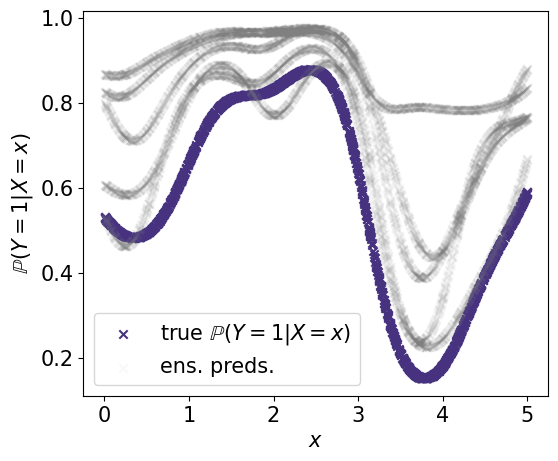

In [6]:
# plot data
sns.set_palette("viridis")
# plot data
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(
    x_train.squeeze(), p_true_train[:, 0], label=r"true $\mathbb{P}(Y=1|X=x)$", marker="x"
)
for i in range(train_set.dataset.n_ens):
    ax.scatter(
        x_train.squeeze(),
        p_pred_train[:, i, 0],
        alpha=0.05,
        label=(f"ens. preds." if i == 0 else None),
        color="gray",
        marker="x",
    )
plt.legend(fontsize=15)
# set size of ticks labels bigger
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$\mathbb{P}(Y=1|X=x)$", fontsize=15)
plt.savefig("../../figures/gp/synthetic_data_gp.png", dpi=300)

Epoch 1/500: train=0.4869, val=0.4578
Epoch 10/500: train=0.4034, val=0.4198
Epoch 20/500: train=0.3951, val=0.4172
Epoch 30/500: train=0.3930, val=0.4171
Epoch 40/500: train=0.3913, val=0.4166
Epoch 50/500: train=0.3900, val=0.4160
Epoch 60/500: train=0.3891, val=0.4154
Epoch 70/500: train=0.3883, val=0.4149
Epoch 80/500: train=0.3879, val=0.4145
Epoch 90/500: train=0.3875, val=0.4142
Epoch 100/500: train=0.3873, val=0.4141
Epoch 110/500: train=0.3872, val=0.4139
Epoch 120/500: train=0.3871, val=0.4137
Epoch 130/500: train=0.3870, val=0.4137
Epoch 140/500: train=0.3870, val=0.4136
Epoch 150/500: train=0.3869, val=0.4136
Epoch 160/500: train=0.3869, val=0.4135
Epoch 170/500: train=0.3869, val=0.4135
Epoch 180/500: train=0.3868, val=0.4137
Epoch 190/500: train=0.3868, val=0.4135
Epoch 200/500: train=0.3868, val=0.4137
Epoch 210/500: train=0.3868, val=0.4136
Epoch 220/500: train=0.3868, val=0.4136
Early stopping at epoch 222
Best epoch: 172, Best val loss: 0.41340159624814987
Stopped ear

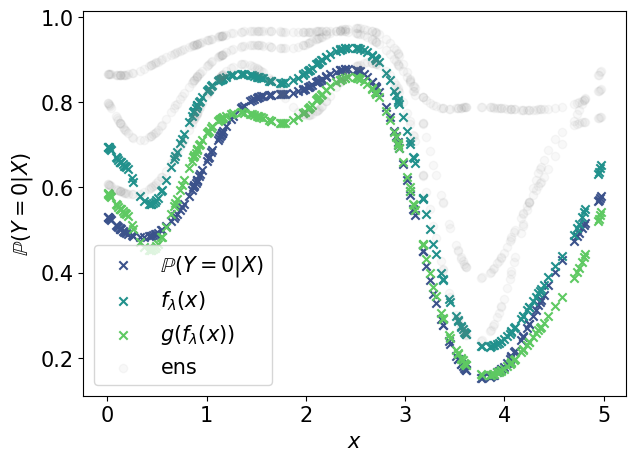

Epoch 1/500: train=0.4706, val=0.4470
Epoch 10/500: train=0.4057, val=0.4176
Epoch 20/500: train=0.4018, val=0.4172
Epoch 30/500: train=0.4013, val=0.4177
Epoch 40/500: train=0.4010, val=0.4179
Epoch 50/500: train=0.4007, val=0.4179
Epoch 60/500: train=0.4004, val=0.4179
Early stopping at epoch 64
Best epoch: 14, Best val loss: 0.416670985519886
Stopped early at epoch 64
Figure saved to: ../../figures/gp/credal_set_gp_brier loss_joint_TemperatureScalingCalibrator.png


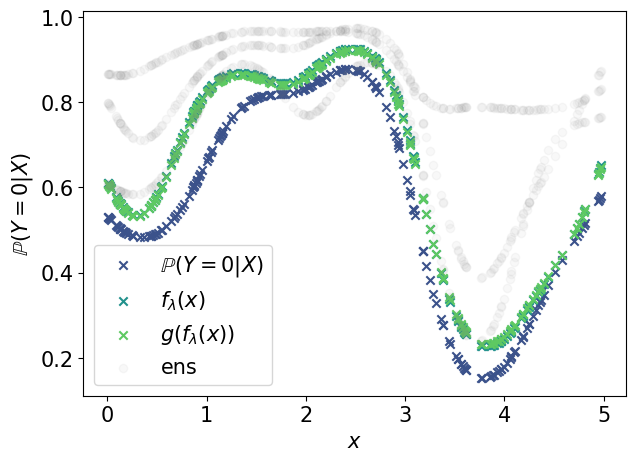

Epoch 1/500: train=0.4987, val=0.4528
Epoch 10/500: train=0.4631, val=0.4181
Epoch 20/500: train=0.4547, val=0.4195
Epoch 30/500: train=0.4492, val=0.4200
Epoch 40/500: train=0.4449, val=0.4201
Epoch 50/500: train=0.4413, val=0.4202
Epoch 60/500: train=0.4382, val=0.4202
Early stopping at epoch 62
Best epoch: 12, Best val loss: 0.41754966229200363
Stopped early at epoch 62
Figure saved to: ../../figures/gp/credal_set_gp_brier loss_joint_LinearCalibrator.png


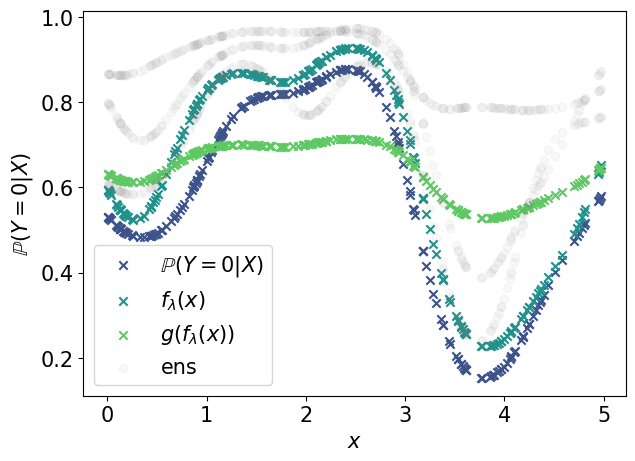

Cycle 1/500: comb_loss=0.4809, cal_loss=0.4753, val=0.4530
Cycle 5/500: comb_loss=0.4364, cal_loss=0.4231, val=0.4301
Cycle 10/500: comb_loss=0.4064, cal_loss=0.4002, val=0.4177
Cycle 15/500: comb_loss=0.4031, cal_loss=0.3964, val=0.4167
Cycle 20/500: comb_loss=0.4026, cal_loss=0.3950, val=0.4173
Cycle 25/500: comb_loss=0.4025, cal_loss=0.3939, val=0.4176
Cycle 30/500: comb_loss=0.4025, cal_loss=0.3930, val=0.4178
Cycle 35/500: comb_loss=0.4025, cal_loss=0.3923, val=0.4180
Cycle 40/500: comb_loss=0.4025, cal_loss=0.3917, val=0.4180
Cycle 45/500: comb_loss=0.4025, cal_loss=0.3912, val=0.4181
Cycle 50/500: comb_loss=0.4025, cal_loss=0.3908, val=0.4181
Cycle 55/500: comb_loss=0.4025, cal_loss=0.3905, val=0.4182
Cycle 60/500: comb_loss=0.4024, cal_loss=0.3902, val=0.4181
Early stopping at epoch 63
Best epoch: 13, Best val loss: 0.41659003496170044
Stopped early at cycle 63
Figure saved to: ../../figures/gp/credal_set_gp_brier loss_alternating_DirichletCalibrator.png


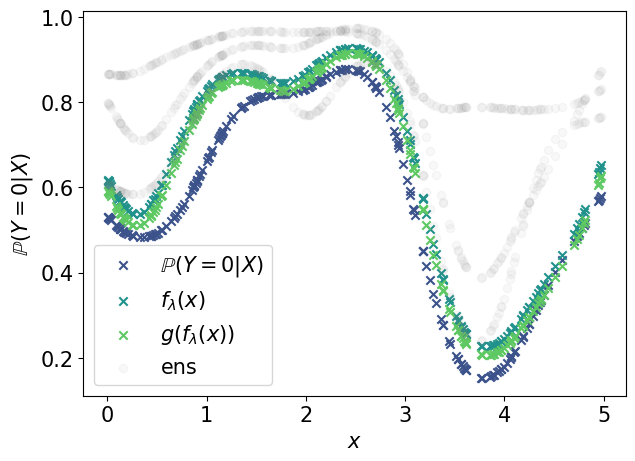

Cycle 1/500: comb_loss=0.4728, cal_loss=0.4692, val=0.4484
Cycle 5/500: comb_loss=0.4274, cal_loss=0.4206, val=0.4263
Cycle 10/500: comb_loss=0.4045, cal_loss=0.4036, val=0.4179
Cycle 15/500: comb_loss=0.4029, cal_loss=0.4022, val=0.4180
Cycle 20/500: comb_loss=0.4026, cal_loss=0.4018, val=0.4183
Cycle 25/500: comb_loss=0.4025, cal_loss=0.4016, val=0.4185
Cycle 30/500: comb_loss=0.4025, cal_loss=0.4014, val=0.4187
Cycle 35/500: comb_loss=0.4025, cal_loss=0.4012, val=0.4187
Cycle 40/500: comb_loss=0.4025, cal_loss=0.4011, val=0.4188
Cycle 45/500: comb_loss=0.4025, cal_loss=0.4009, val=0.4188
Cycle 50/500: comb_loss=0.4025, cal_loss=0.4008, val=0.4187
Cycle 55/500: comb_loss=0.4025, cal_loss=0.4006, val=0.4188
Cycle 60/500: comb_loss=0.4025, cal_loss=0.4005, val=0.4188
Early stopping at epoch 61
Best epoch: 11, Best val loss: 0.4178207293152809
Stopped early at cycle 61
Figure saved to: ../../figures/gp/credal_set_gp_brier loss_alternating_TemperatureScalingCalibrator.png


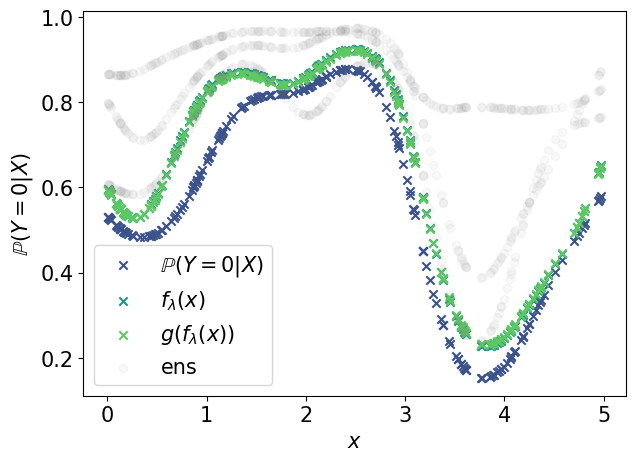

Cycle 1/500: comb_loss=0.4819, cal_loss=0.4600, val=0.4540
Cycle 5/500: comb_loss=0.4456, cal_loss=0.4351, val=0.4328
Cycle 10/500: comb_loss=0.4061, cal_loss=0.4171, val=0.4177
Cycle 15/500: comb_loss=0.4029, cal_loss=0.4147, val=0.4176
Cycle 20/500: comb_loss=0.4026, cal_loss=0.4135, val=0.4180
Cycle 25/500: comb_loss=0.4026, cal_loss=0.4125, val=0.4182
Cycle 30/500: comb_loss=0.4025, cal_loss=0.4116, val=0.4185
Cycle 35/500: comb_loss=0.4025, cal_loss=0.4108, val=0.4185
Cycle 40/500: comb_loss=0.4025, cal_loss=0.4101, val=0.4185
Cycle 45/500: comb_loss=0.4025, cal_loss=0.4095, val=0.4186
Cycle 50/500: comb_loss=0.4025, cal_loss=0.4089, val=0.4186
Cycle 55/500: comb_loss=0.4025, cal_loss=0.4083, val=0.4186
Cycle 60/500: comb_loss=0.4025, cal_loss=0.4077, val=0.4185
Early stopping at epoch 62
Best epoch: 12, Best val loss: 0.4172034487128258
Stopped early at cycle 62
Figure saved to: ../../figures/gp/credal_set_gp_brier loss_alternating_LinearCalibrator.png


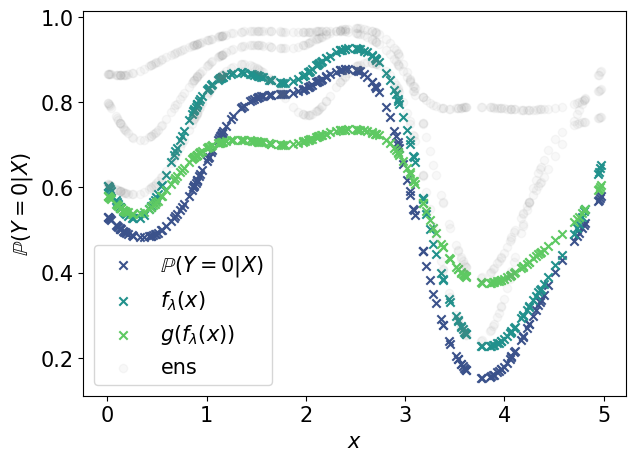

Epoch 1/500: train=0.4779, val=0.4524
Epoch 10/500: train=0.4618, val=0.4423
Epoch 20/500: train=0.4458, val=0.4326
Epoch 30/500: train=0.4320, val=0.4250
Epoch 40/500: train=0.4205, val=0.4194
Epoch 50/500: train=0.4114, val=0.4157
Epoch 60/500: train=0.4046, val=0.4138
Epoch 70/500: train=0.3998, val=0.4132
Epoch 80/500: train=0.3965, val=0.4135
Epoch 90/500: train=0.3944, val=0.4144
Epoch 100/500: train=0.3931, val=0.4155
Epoch 110/500: train=0.3923, val=0.4165
Epoch 120/500: train=0.3917, val=0.4174
Early stopping at epoch 121
Best epoch: 71, Best val loss: 0.41317541897296906
Stopped early at epoch 121
Figure saved to: ../../figures/gp/credal_set_gp_brier loss_avg_then_calibrate_DirichletCalibrator.png


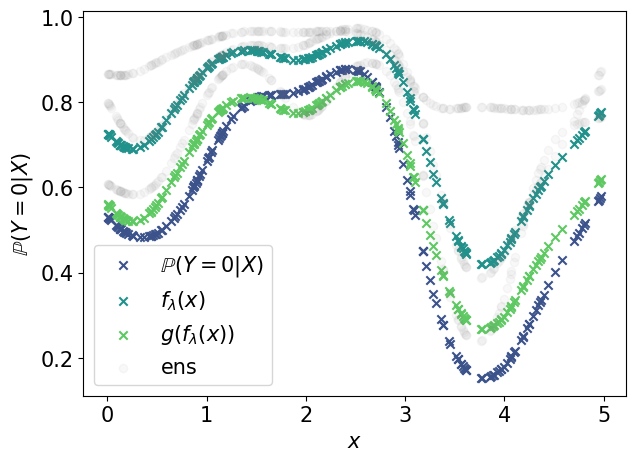

Epoch 1/500: train=0.4787, val=0.4535
Epoch 10/500: train=0.4765, val=0.4518
Epoch 20/500: train=0.4742, val=0.4500
Epoch 30/500: train=0.4720, val=0.4483
Epoch 40/500: train=0.4699, val=0.4467
Epoch 50/500: train=0.4679, val=0.4452
Epoch 60/500: train=0.4659, val=0.4437
Epoch 70/500: train=0.4641, val=0.4423
Epoch 80/500: train=0.4623, val=0.4410
Epoch 90/500: train=0.4606, val=0.4398
Epoch 100/500: train=0.4590, val=0.4386
Epoch 110/500: train=0.4575, val=0.4375
Epoch 120/500: train=0.4561, val=0.4365
Epoch 130/500: train=0.4547, val=0.4355
Epoch 140/500: train=0.4534, val=0.4346
Epoch 150/500: train=0.4522, val=0.4338
Epoch 160/500: train=0.4511, val=0.4330
Epoch 170/500: train=0.4500, val=0.4323
Epoch 180/500: train=0.4490, val=0.4316
Epoch 190/500: train=0.4480, val=0.4310
Epoch 200/500: train=0.4471, val=0.4304
Epoch 210/500: train=0.4463, val=0.4299
Epoch 220/500: train=0.4456, val=0.4295
Epoch 230/500: train=0.4449, val=0.4290
Epoch 240/500: train=0.4442, val=0.4287
Epoch 250/5

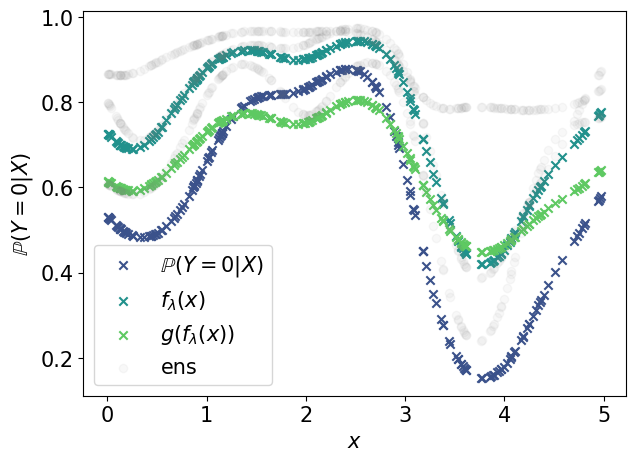

Epoch 1/500: train=0.4854, val=0.5065
Epoch 10/500: train=0.4770, val=0.4950
Epoch 20/500: train=0.4694, val=0.4845
Epoch 30/500: train=0.4632, val=0.4760
Epoch 40/500: train=0.4583, val=0.4690
Epoch 50/500: train=0.4542, val=0.4634
Epoch 60/500: train=0.4508, val=0.4587
Epoch 70/500: train=0.4480, val=0.4548
Epoch 80/500: train=0.4455, val=0.4516
Epoch 90/500: train=0.4433, val=0.4490
Epoch 100/500: train=0.4413, val=0.4467
Epoch 110/500: train=0.4394, val=0.4447
Epoch 120/500: train=0.4377, val=0.4430
Epoch 130/500: train=0.4361, val=0.4416
Epoch 140/500: train=0.4345, val=0.4401
Epoch 150/500: train=0.4330, val=0.4390
Epoch 160/500: train=0.4316, val=0.4378
Epoch 170/500: train=0.4302, val=0.4368
Epoch 180/500: train=0.4289, val=0.4359
Epoch 190/500: train=0.4276, val=0.4350
Epoch 200/500: train=0.4263, val=0.4341
Epoch 210/500: train=0.4251, val=0.4334
Epoch 220/500: train=0.4239, val=0.4326
Epoch 230/500: train=0.4227, val=0.4320
Epoch 240/500: train=0.4216, val=0.4313
Epoch 250/5

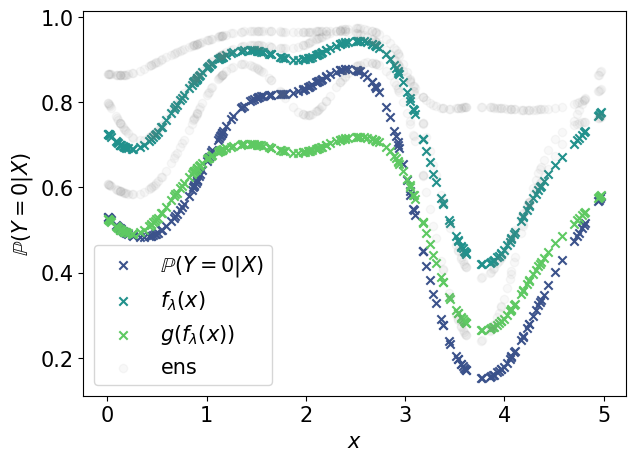

Epoch 1/500: train=0.6767, val=0.6510
Epoch 10/500: train=0.5872, val=0.6083
Epoch 20/500: train=0.5818, val=0.6079
Epoch 30/500: train=0.5785, val=0.6077
Epoch 40/500: train=0.5762, val=0.6072
Epoch 50/500: train=0.5746, val=0.6065
Epoch 60/500: train=0.5734, val=0.6056
Epoch 70/500: train=0.5726, val=0.6049
Epoch 80/500: train=0.5720, val=0.6044
Epoch 90/500: train=0.5716, val=0.6039
Epoch 100/500: train=0.5715, val=0.6038
Epoch 110/500: train=0.5713, val=0.6035
Epoch 120/500: train=0.5711, val=0.6033
Epoch 130/500: train=0.5710, val=0.6032
Epoch 140/500: train=0.5710, val=0.6033
Epoch 150/500: train=0.5709, val=0.6031
Epoch 160/500: train=0.5709, val=0.6030
Epoch 170/500: train=0.5708, val=0.6030
Epoch 180/500: train=0.5708, val=0.6032
Epoch 190/500: train=0.5708, val=0.6031
Epoch 200/500: train=0.5709, val=0.6029
Epoch 210/500: train=0.5708, val=0.6030
Epoch 220/500: train=0.5708, val=0.6031
Epoch 230/500: train=0.5707, val=0.6030
Epoch 240/500: train=0.5708, val=0.6030
Epoch 250/5

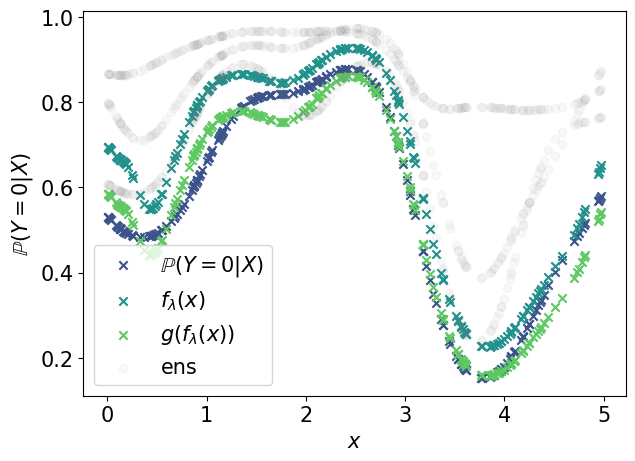

Epoch 1/500: train=0.6885, val=0.6603
Epoch 10/500: train=0.5948, val=0.6086
Epoch 20/500: train=0.5913, val=0.6077
Epoch 30/500: train=0.5905, val=0.6081
Epoch 40/500: train=0.5898, val=0.6082
Epoch 50/500: train=0.5892, val=0.6082
Epoch 60/500: train=0.5886, val=0.6082
Early stopping at epoch 64
Best epoch: 14, Best val loss: 0.607383981347084
Stopped early at epoch 64
Figure saved to: ../../figures/gp/credal_set_gp_log loss_joint_TemperatureScalingCalibrator.png


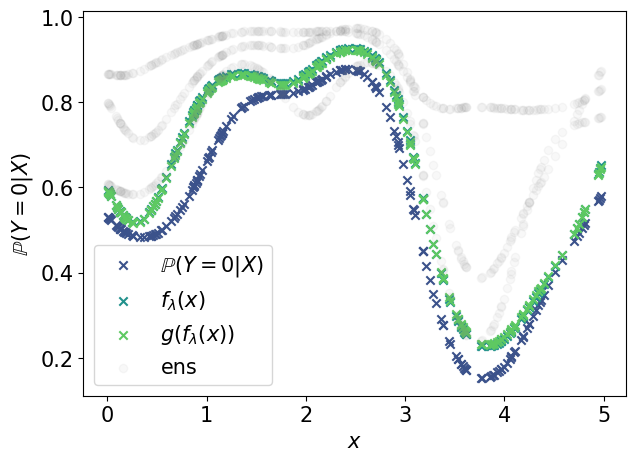

Epoch 1/500: train=0.7182, val=0.6698
Epoch 10/500: train=0.7009, val=0.7940
Epoch 20/500: train=0.6983, val=0.7705
Epoch 30/500: train=0.6930, val=0.7512
Epoch 40/500: train=0.6915, val=0.7546
Epoch 50/500: train=0.6909, val=0.7653
Early stopping at epoch 51
Best epoch: 1, Best val loss: 0.6697535812854767
Stopped early at epoch 51
Figure saved to: ../../figures/gp/credal_set_gp_log loss_joint_LinearCalibrator.png


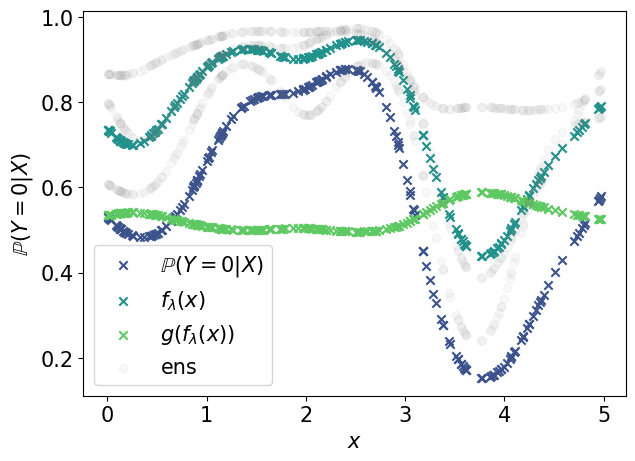

Cycle 1/500: comb_loss=0.6883, cal_loss=0.6826, val=0.6591
Cycle 5/500: comb_loss=0.6281, cal_loss=0.6117, val=0.6258
Cycle 10/500: comb_loss=0.5953, cal_loss=0.5872, val=0.6076
Cycle 15/500: comb_loss=0.5931, cal_loss=0.5838, val=0.6072
Cycle 20/500: comb_loss=0.5928, cal_loss=0.5818, val=0.6076
Cycle 25/500: comb_loss=0.5927, cal_loss=0.5802, val=0.6078
Cycle 30/500: comb_loss=0.5927, cal_loss=0.5788, val=0.6079
Cycle 35/500: comb_loss=0.5927, cal_loss=0.5777, val=0.6080
Cycle 40/500: comb_loss=0.5927, cal_loss=0.5767, val=0.6080
Cycle 45/500: comb_loss=0.5927, cal_loss=0.5760, val=0.6081
Cycle 50/500: comb_loss=0.5927, cal_loss=0.5754, val=0.6080
Cycle 55/500: comb_loss=0.5927, cal_loss=0.5749, val=0.6080
Cycle 60/500: comb_loss=0.5927, cal_loss=0.5746, val=0.6081
Early stopping at epoch 63
Best epoch: 13, Best val loss: 0.6070698201656342
Stopped early at cycle 63
Figure saved to: ../../figures/gp/credal_set_gp_log loss_alternating_DirichletCalibrator.png


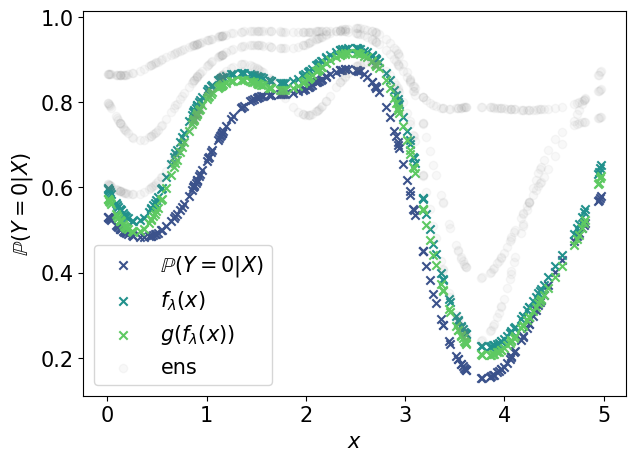

Cycle 1/500: comb_loss=0.6867, cal_loss=0.6828, val=0.6576
Cycle 5/500: comb_loss=0.6242, cal_loss=0.6139, val=0.6216
Cycle 10/500: comb_loss=0.5948, cal_loss=0.5933, val=0.6083
Cycle 15/500: comb_loss=0.5931, cal_loss=0.5918, val=0.6079
Cycle 20/500: comb_loss=0.5928, cal_loss=0.5912, val=0.6081
Cycle 25/500: comb_loss=0.5928, cal_loss=0.5908, val=0.6083
Cycle 30/500: comb_loss=0.5928, cal_loss=0.5904, val=0.6083
Cycle 35/500: comb_loss=0.5927, cal_loss=0.5901, val=0.6085
Cycle 40/500: comb_loss=0.5927, cal_loss=0.5898, val=0.6085
Cycle 45/500: comb_loss=0.5927, cal_loss=0.5894, val=0.6085
Cycle 50/500: comb_loss=0.5927, cal_loss=0.5892, val=0.6085
Cycle 55/500: comb_loss=0.5927, cal_loss=0.5889, val=0.6085
Cycle 60/500: comb_loss=0.5927, cal_loss=0.5886, val=0.6085
Early stopping at epoch 63
Best epoch: 13, Best val loss: 0.6078453660011292
Stopped early at cycle 63
Figure saved to: ../../figures/gp/credal_set_gp_log loss_alternating_TemperatureScalingCalibrator.png


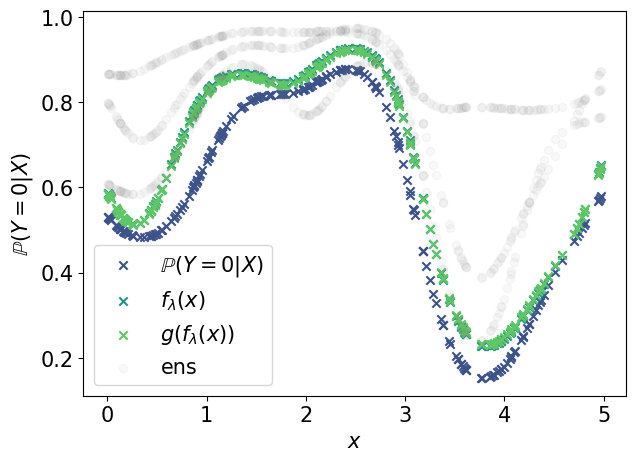

Cycle 1/500: comb_loss=0.6822, cal_loss=0.7797, val=0.6548
Cycle 5/500: comb_loss=0.6265, cal_loss=0.7747, val=0.6244
Cycle 10/500: comb_loss=0.5964, cal_loss=0.7669, val=0.6088
Cycle 15/500: comb_loss=0.5934, cal_loss=0.7590, val=0.6076
Cycle 20/500: comb_loss=0.5929, cal_loss=0.7517, val=0.6078
Cycle 25/500: comb_loss=0.5928, cal_loss=0.7448, val=0.6080
Cycle 30/500: comb_loss=0.5928, cal_loss=0.7384, val=0.6082
Cycle 35/500: comb_loss=0.5927, cal_loss=0.7326, val=0.6083
Cycle 40/500: comb_loss=0.5927, cal_loss=0.7272, val=0.6084
Cycle 45/500: comb_loss=0.5927, cal_loss=0.7222, val=0.6083
Cycle 50/500: comb_loss=0.5927, cal_loss=0.7175, val=0.6083
Cycle 55/500: comb_loss=0.5927, cal_loss=0.7133, val=0.6084
Cycle 60/500: comb_loss=0.5927, cal_loss=0.7093, val=0.6084
Early stopping at epoch 64
Best epoch: 14, Best val loss: 0.6075410097837448
Stopped early at cycle 64
Figure saved to: ../../figures/gp/credal_set_gp_log loss_alternating_LinearCalibrator.png


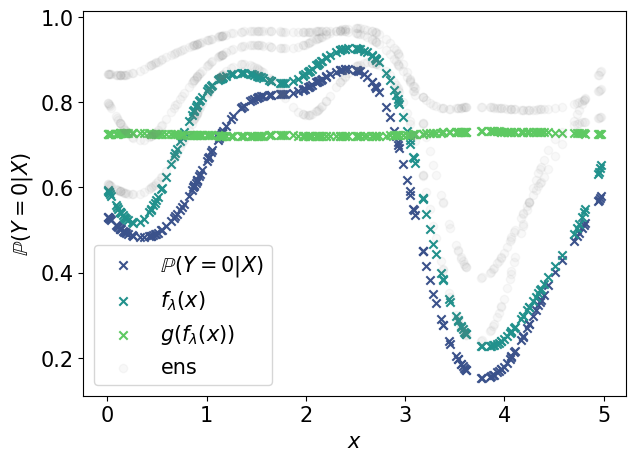

Epoch 1/500: train=0.6881, val=0.6598
Epoch 10/500: train=0.6658, val=0.6441
Epoch 20/500: train=0.6446, val=0.6300
Epoch 30/500: train=0.6273, val=0.6193
Epoch 40/500: train=0.6134, val=0.6115
Epoch 50/500: train=0.6026, val=0.6062
Epoch 60/500: train=0.5945, val=0.6031
Epoch 70/500: train=0.5886, val=0.6017
Epoch 80/500: train=0.5844, val=0.6014
Epoch 90/500: train=0.5816, val=0.6019
Epoch 100/500: train=0.5798, val=0.6029
Epoch 110/500: train=0.5786, val=0.6040
Epoch 120/500: train=0.5777, val=0.6051
Early stopping at epoch 127
Best epoch: 77, Best val loss: 0.6013948172330856
Stopped early at epoch 127
Figure saved to: ../../figures/gp/credal_set_gp_log loss_avg_then_calibrate_DirichletCalibrator.png


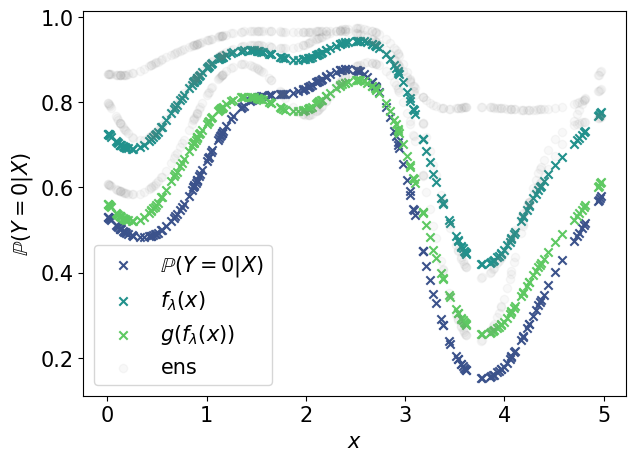

Epoch 1/500: train=0.6893, val=0.6614
Epoch 10/500: train=0.6852, val=0.6580
Epoch 20/500: train=0.6809, val=0.6544
Epoch 30/500: train=0.6769, val=0.6511
Epoch 40/500: train=0.6732, val=0.6480
Epoch 50/500: train=0.6697, val=0.6452
Epoch 60/500: train=0.6665, val=0.6426
Epoch 70/500: train=0.6635, val=0.6402
Epoch 80/500: train=0.6608, val=0.6379
Epoch 90/500: train=0.6582, val=0.6359
Epoch 100/500: train=0.6557, val=0.6339
Epoch 110/500: train=0.6535, val=0.6322
Epoch 120/500: train=0.6514, val=0.6305
Epoch 130/500: train=0.6494, val=0.6290
Epoch 140/500: train=0.6476, val=0.6276
Epoch 150/500: train=0.6459, val=0.6263
Epoch 160/500: train=0.6443, val=0.6251
Epoch 170/500: train=0.6428, val=0.6240
Epoch 180/500: train=0.6414, val=0.6230
Epoch 190/500: train=0.6402, val=0.6221
Epoch 200/500: train=0.6390, val=0.6213
Epoch 210/500: train=0.6379, val=0.6205
Epoch 220/500: train=0.6369, val=0.6199
Epoch 230/500: train=0.6360, val=0.6192
Epoch 240/500: train=0.6351, val=0.6187
Epoch 250/5

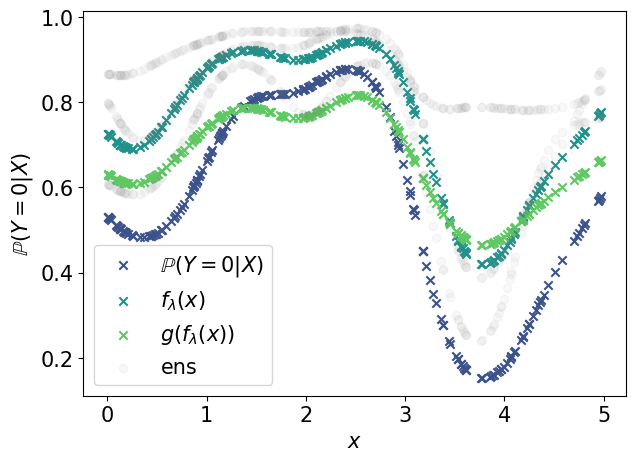

Epoch 1/500: train=0.8068, val=0.8436
Epoch 10/500: train=0.7884, val=0.8210
Epoch 20/500: train=0.7706, val=0.7987
Epoch 30/500: train=0.7551, val=0.7793
Epoch 40/500: train=0.7417, val=0.7622
Epoch 50/500: train=0.7300, val=0.7472
Epoch 60/500: train=0.7197, val=0.7342
Epoch 70/500: train=0.7108, val=0.7227
Epoch 80/500: train=0.7029, val=0.7125
Epoch 90/500: train=0.6958, val=0.7035
Epoch 100/500: train=0.6896, val=0.6956
Epoch 110/500: train=0.6841, val=0.6885
Epoch 120/500: train=0.6792, val=0.6823
Epoch 130/500: train=0.6749, val=0.6767
Epoch 140/500: train=0.6710, val=0.6719
Epoch 150/500: train=0.6675, val=0.6676
Epoch 160/500: train=0.6643, val=0.6637
Epoch 170/500: train=0.6614, val=0.6603
Epoch 180/500: train=0.6587, val=0.6572
Epoch 190/500: train=0.6561, val=0.6544
Epoch 200/500: train=0.6537, val=0.6519
Epoch 210/500: train=0.6515, val=0.6496
Epoch 220/500: train=0.6493, val=0.6476
Epoch 230/500: train=0.6472, val=0.6456
Epoch 240/500: train=0.6452, val=0.6439
Epoch 250/5

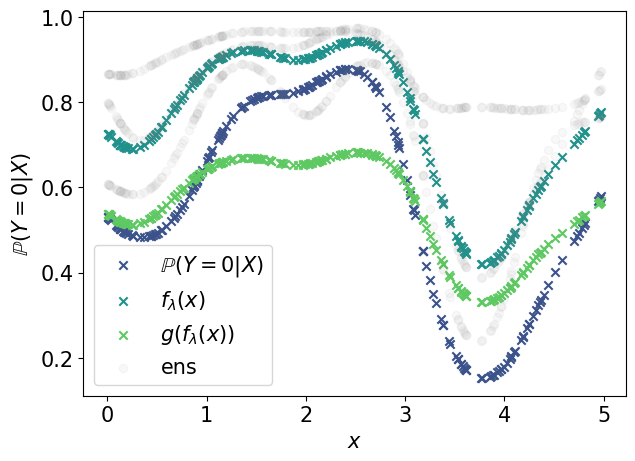

In [ ]:
# model = CredalSetCalibrator(comb_model=MLPCalW, cal_model=DirichletCalibrator, in_channels=1,
#                            n_classes=2,n_ensembles=3, hidden_dim=64, hidden_layers=3)

losses = [GeneralizedBrierLoss(), GeneralizedLogLoss()]
train_modes = ["joint", "alternating", "avg_then_calibrate"]
cal_models = [DirichletCalibrator, TemperatureScalingCalibrator]

# save scores in dict
scores_cal = {}
preds_cal = {}

for loss in losses:
    for train_mode in train_modes:
        for cal_model in cal_models:
            model = CredalSetCalibrator(
                comb_model=MLPCalW,
                cal_model=cal_model,
                in_channels=1,
                n_classes=2,
                n_ensembles=config["dataset"]["n_ens"],
                hidden_dim=64,
                hidden_layers=3,
            )
            model, loss_train, loss_val = train_model(
                model,
                dataset_train=train_set,
                loss_fn=loss,
                train_mode=train_mode,
                dataset_val=val_set,
                n_epochs=500,
                lr=1e-4,
                batch_size=64,
                verbose=True,
                early_stopping=True,
                patience=50
            )
            # save predictions for calibration
            outputs = model(x_val, p_pred_val)
            if len(outputs) == 3:
                p_cal, p_bar, weights = outputs
            elif len(outputs) == 2:
                p_cal, p_bar = outputs
                weights = None
            
            preds_cal[(loss.__name__, train_mode, cal_model.__name__)] = p_cal


            # if train_mode not in ["joint", "alternating"]:
            #     plot_ens_comb_cal(
            #         experiment=None,
            #         x_inst=x_val,
            #         p_true=p_true_val,
            #         ens_preds=p_pred_val,
            #         model=model,
            #         file_name=f"credal_set_gp_{loss.__name__}_{train_mode}_{cal_model.__name__}.png",
            #         title=None,
            #         output_path="../../figures/gp/",
            #         alpha_comb=1.0,
            #         output_pbar="average"
            #     )
            # else:
            #     plot_ens_comb_cal(
            #         experiment=None,
            #         x_inst=x_val,
            #         p_true=p_true_val,
            #         ens_preds=p_pred_val,
            #         model=model,
            #         file_name=f"credal_set_gp_{loss.__name__}_{train_mode}_{cal_model.__name__}.png",
            #         title=None,
            #         output_path="../../figures/gp/",
            #         alpha_comb=1.0,
            #         output_pbar="weighted"
            #     )
            # plt.show()

### 2. Experiment

According to Vaicenavicious et al.

load config:

In [15]:
config = load_config("../configs/log_experiment.yml")
dataset_cfg = config["dataset"]
dataset_method = dataset_cfg["method"]



split data:

In [3]:
train_set, val_set, test_set = create_synthetic_dataset(dataset_cfg)


In [13]:
p_true_train = train_set.dataset.p_true[train_set.indices]
p_pred_train = train_set.dataset.p_probs[train_set.indices]
y_train = train_set.dataset.y_true[train_set.indices]
x_train = train_set.dataset.x_train[train_set.indices]

# validation data
p_true_val = val_set.dataset.p_true[val_set.indices]
p_pred_val = val_set.dataset.p_probs[val_set.indices]
y_val = val_set.dataset.y_true[val_set.indices]
x_val = val_set.dataset.x_train[val_set.indices]

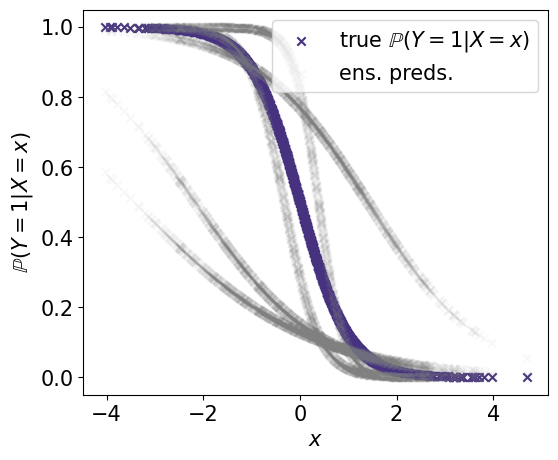

In [14]:
sns.set_palette("viridis")
# plot data
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(
    x_train.squeeze(), p_true_train[:, 0], label=r"true $\mathbb{P}(Y=1|X=x)$", marker="x"
)
for i in range(train_set.dataset.n_ens):
    ax.scatter(
        x_train.squeeze(),
        p_pred_train[:, i, 0],
        alpha=0.05,
        label=(f"ens. preds." if i == 0 else None),
        color="gray",
        marker="x",
    )
plt.legend(fontsize=15)
# set size of ticks labels bigger
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$\mathbb{P}(Y=1|X=x)$", fontsize=15)
plt.savefig("../../figures/log/synthetic_data_log.png", dpi=300)

Epoch 1/500: train=0.2815, val=0.2835
Epoch 10/500: train=0.2338, val=0.2814
Epoch 20/500: train=0.2327, val=0.2842
Epoch 30/500: train=0.2326, val=0.2846
Epoch 40/500: train=0.2325, val=0.2846
Epoch 50/500: train=0.2325, val=0.2852
Early stopping at epoch 55
Best epoch: 5, Best val loss: 0.2761768251657486
Stopped early at epoch 55
Figure saved to: ../../figures/log/credal_set_log_brier loss_joint_DirichletCalibrator.png
Epoch 1/500: train=0.2760, val=0.2808
Epoch 10/500: train=0.2337, val=0.2832
Epoch 20/500: train=0.2329, val=0.2850
Epoch 30/500: train=0.2327, val=0.2853
Epoch 40/500: train=0.2326, val=0.2858
Epoch 50/500: train=0.2326, val=0.2857
Early stopping at epoch 54
Best epoch: 4, Best val loss: 0.275347463786602
Stopped early at epoch 54
Figure saved to: ../../figures/log/credal_set_log_brier loss_joint_TemperatureScalingCalibrator.png
Cycle 1/500: comb_loss=0.2767, cal_loss=0.2727, val=0.2820
Cycle 5/500: comb_loss=0.2446, cal_loss=0.2407, val=0.2764
Cycle 10/500: comb_los

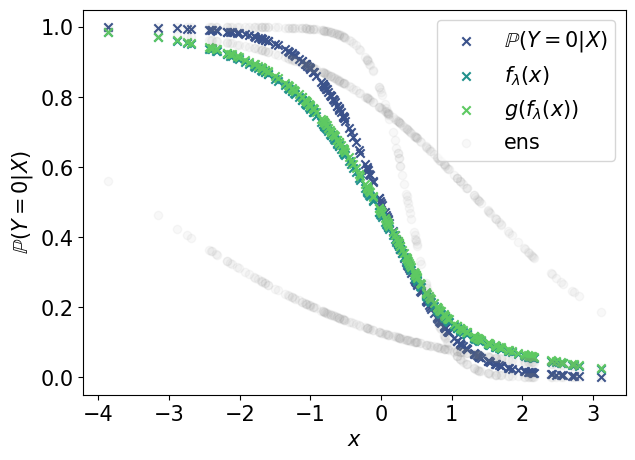

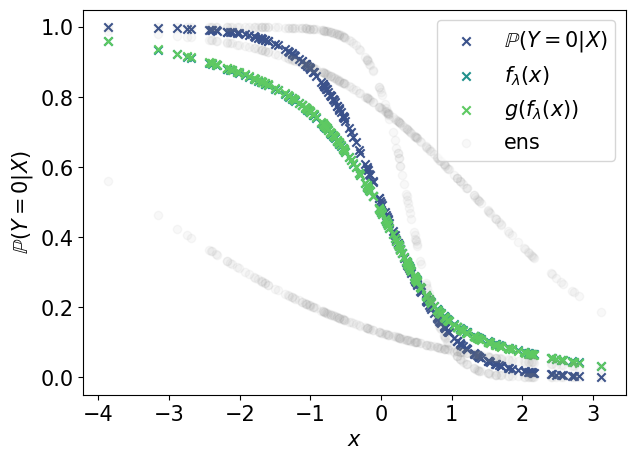

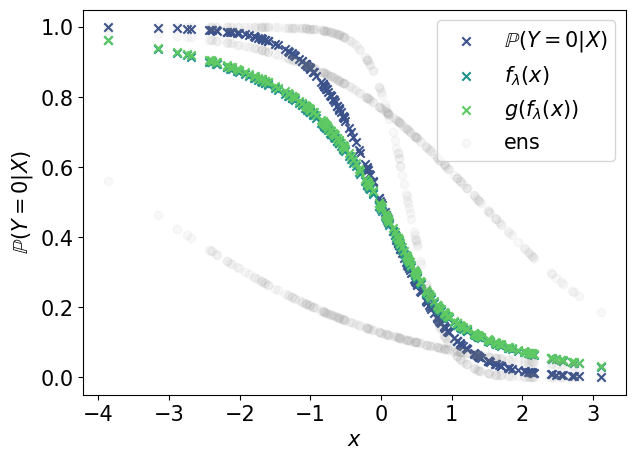

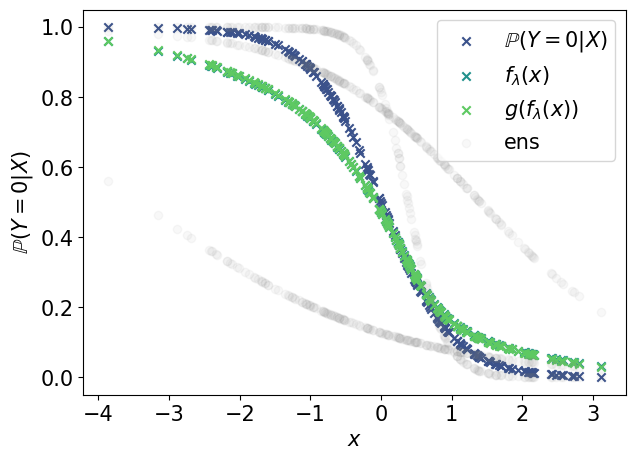

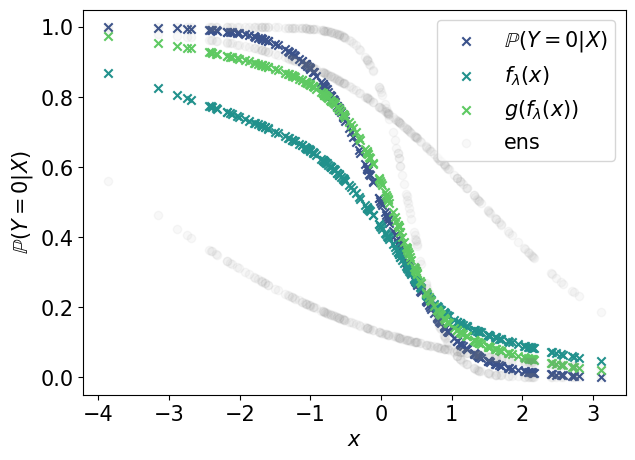

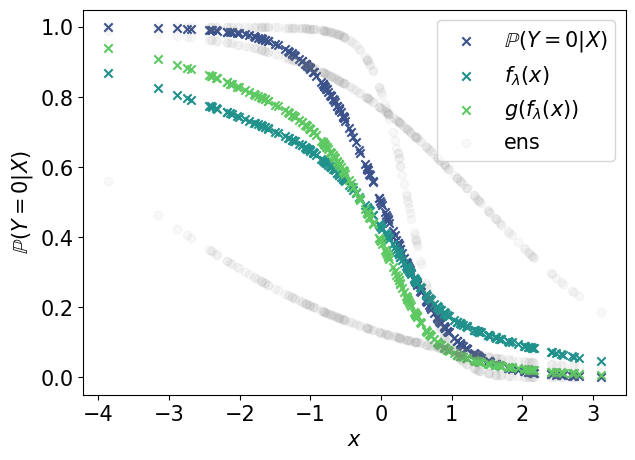

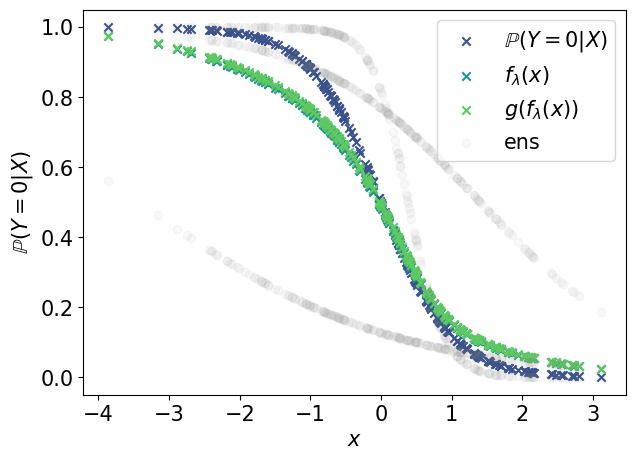

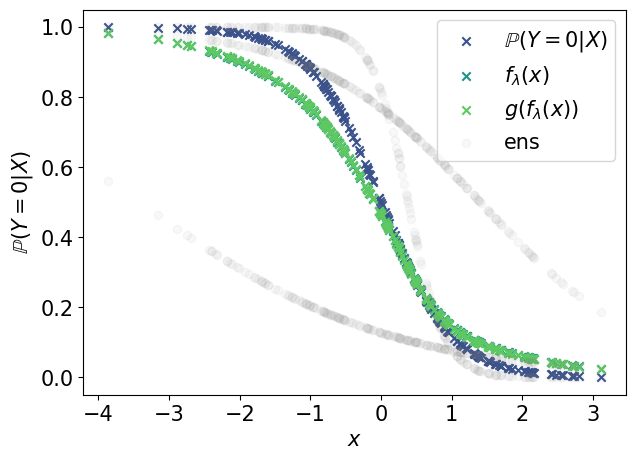

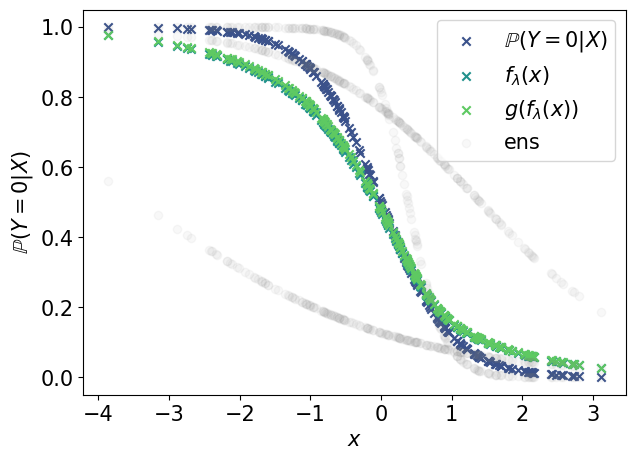

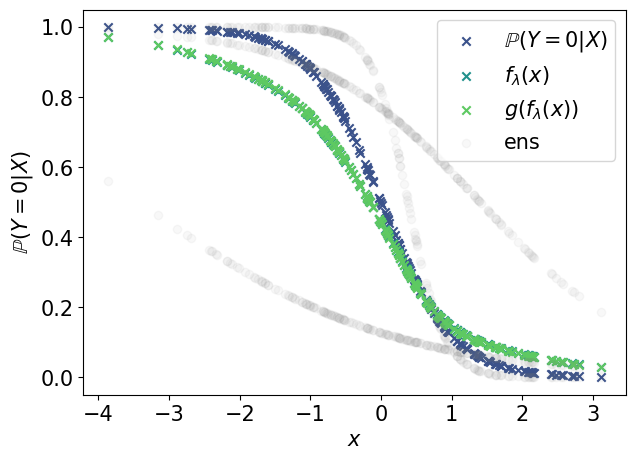

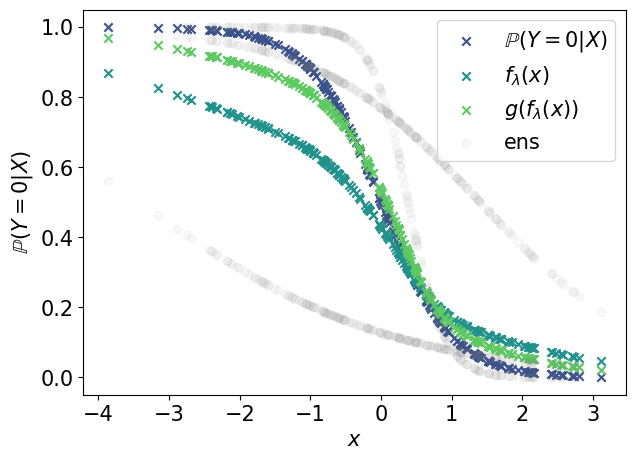

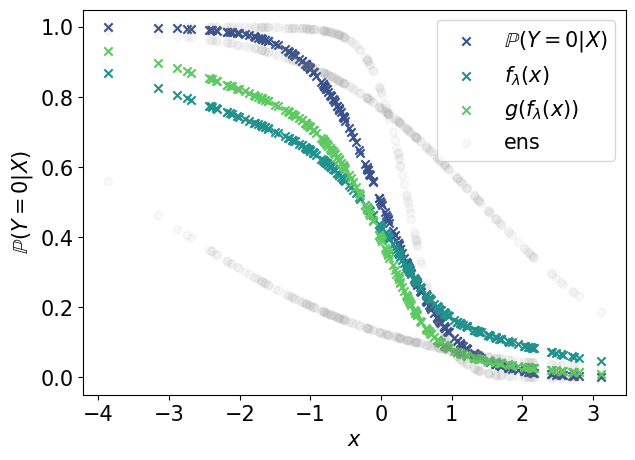

In [22]:
# train model
losses = [GeneralizedBrierLoss(), GeneralizedLogLoss()]
train_modes = ["joint", "alternating", "avg_then_calibrate"]
cal_models = [DirichletCalibrator, TemperatureScalingCalibrator]

# save scores in dict
scores_cal = {}

for loss_obj in losses:
    loss_name = loss_obj.__class__.__name__
    for train_mode in train_modes:
        for cal_model in cal_models:
            cal_model_name = cal_model.__name__
            model = CredalSetCalibrator(
                comb_model=MLPCalW,
                cal_model=cal_model,
                in_channels=1,
                n_classes=2,
                n_ensembles=config["dataset"]["n_ens"],
                hidden_dim=64,
                hidden_layers=2,
            )
            model, loss_train, loss_val = train_model(
                model,
                dataset_train=train_set,
                loss_fn=loss_obj,
                train_mode=train_mode,
                dataset_val=val_set,
                n_epochs=500,
                lr=1e-4,
                batch_size=64,
                verbose=True,
                early_stopping=True,
                patience=50,
            )
            if train_mode not in ["joint", "alternating"]:
                plot_ens_comb_cal(
                    experiment=None,
                    x_inst=x_val,
                    p_true=p_true_val,
                    ens_preds=p_pred_val,
                    model=model,
                    file_name=f"credal_set_log_{loss_obj.__name__}_{train_mode}_{cal_model_name}.png",
                    title=None,
                    output_path="../../figures/log/",
                    alpha_comb=1.0,
                    output_pbar="average",
                )
            else:
                plot_ens_comb_cal(
                    experiment=None,
                    x_inst=x_val,
                    p_true=p_true_val,
                    ens_preds=p_pred_val,
                    model=model,
                    file_name=f"credal_set_log_{loss_obj.__name__}_{train_mode}_{cal_model_name}.png",
                    title=None,
                    output_path="../../figures/log/",
                    alpha_comb=1.0,
                    output_pbar="weighted",
                )

            with torch.no_grad():
                if train_mode in ["joint", "alternating"]:
                    p_cal_val, p_bar_val, weights_l_val = model(x_val, p_pred_val)

                else:
                    # average first
                    p_bar_val = p_pred_val.mean(dim=1)
                    p_cal_val = model.cal_model(p_bar_val)

            p_cal_numpy = p_cal_val.detach().numpy()
            y_val_np = y_val.detach().numpy()

            # calculate scores
            skce_val = get_skce_ul(
                p_bar=p_cal_val, y=y_val, bw=config["dict_skce"]["bw"]
            )
            ece_kde_val = get_ece_kde(
                p_bar=p_cal_val,
                y=y_val,
                p=config["dict_kde_ece"]["p"],
                bw=config["dict_kde_ece"]["bw"],
            )
            brier_val = brier_obj(p_bar=p_cal_val, y=y_val, params={})
            mmd_val = mmd_kce(p_bar=p_cal_val, y=y_val, bw=config["dict_mmd"]["bw"])

            skce_val = (
                float(torch.abs(skce_val))
                if isinstance(skce_val, torch.Tensor)
                else abs(skce_val)
            )
            ece_kde_val = (
                float(torch.abs(ece_kde_val))
                if isinstance(ece_kde_val, torch.Tensor)
                else abs(ece_kde_val)
            )
            brier_val = (
                float(torch.abs(brier_val))
                if isinstance(brier_val, torch.Tensor)
                else abs(brier_val)
            )
            mmd_val = (
                float(torch.abs(mmd_val))
                if isinstance(mmd_val, torch.Tensor)
                else abs(mmd_val)
            )

            key = (loss_name, train_mode, cal_model_name)
            scores_cal[key] = {
                "skce": skce_val,
                "ece_kde": ece_kde_val,
                "brier": brier_val,
                "mmd": mmd_val,
            }

In [29]:
def save_metric_pivoted(
    scores_cal: dict,
    metric_name: str,
    csv_path: str,
    train_modes=("joint", "alternating", "avg_then_calibrate")
):
    """
    Saves one metric (e.g. 'brier', 'mmd') in a pivoted table:
      - Rows: (loss, calibrator) pairs
      - Columns: each train_mode in train_modes

    scores_cal is a dict like:
      {
        (loss_name, train_mode, cal_model_name): {
            'skce': float,
            'ece_kde': float,
            'brier': float,
            'mmd': float
        },
        ...
      }

    metric_name: the key in the inner dict (e.g. 'brier', 'mmd', 'skce', etc.)
    csv_path: path to write the CSV. We'll ensure the directory exists.
    train_modes: a tuple of column names for the methods.

    The resulting CSV columns are:
      ['(loss,calibrator)', 'joint', 'alternating', 'avg_then_calibrate']
    or some variation, depending on train_modes.
    """
    # 1) Make sure the output directory exists
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)

    # 2) Gather unique (loss_name, cal_model_name) from the dict
    row_keys = set()
    for (loss_name, tm, cal_model_name) in scores_cal.keys():
        row_keys.add((loss_name, cal_model_name))

    # Convert to a sorted list if you prefer sorted rows
    row_keys = sorted(row_keys)

    # 3) We'll build a dict: pivoted_rows[(loss,cal)] = {tm: metric_value, ...}
    pivoted_rows = {}
    for (loss_name, cal_model_name) in row_keys:
        pivoted_rows[(loss_name, cal_model_name)] = {}

    for (loss_name, tm, cal_model_name), metric_dict in scores_cal.items():
        # e.g. metric_dict might have {"brier": 0.1, "mmd":0.05, ...}
        val = metric_dict.get(metric_name, None)
        if val is not None:
            # store in pivoted structure
            pivoted_rows[(loss_name, cal_model_name)][tm] = val

    # 4) Now write to CSV
    #   columns = ["(loss,calibrator)", "joint", "alternating", "avg_then_calibrate", ...]
    columns = ["(loss,cal)"] + list(train_modes)

    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        # header row
        writer.writerow(columns)

        # each row = (loss, cal), then the metric for each train_mode
        for (loss_name, cal_model_name) in row_keys:
            row_label = f"({loss_name},{cal_model_name})"
            row_values = [pivoted_rows[(loss_name, cal_model_name)].get(tm, "")
                          for tm in train_modes]
            row = [row_label] + row_values
            writer.writerow(row)

    print(f"Saved pivoted {metric_name} scores to {csv_path}")


In [33]:
save_metric_pivoted(scores_cal, metric_name="brier", csv_path="../results/log/brier_scores_log_synthetic.csv")
save_metric_pivoted(scores_cal, metric_name="skce", csv_path="../results/log/skce_scores_log_synthetic.csv")
save_metric_pivoted(scores_cal, metric_name="ece_kde", csv_path="../results/log/ece_kde_scores_log_synthetic.csv")
save_metric_pivoted(scores_cal, metric_name="mmd", csv_path="../results/log/mmd_scores_log_synthetic.csv")

Saved pivoted brier scores to ../results/log/brier_scores_log_synthetic.csv
Saved pivoted skce scores to ../results/log/skce_scores_log_synthetic.csv
Saved pivoted ece_kde scores to ../results/log/ece_kde_scores_log_synthetic.csv
Saved pivoted mmd scores to ../results/log/mmd_scores_log_synthetic.csv
